In [1]:
"""
图像增广--对训练图像应用随机变化，生成相似但不同的训练样本
1.扩大训练集规模
2.减少对某些属性的依赖，提高模型泛化能力
"""
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

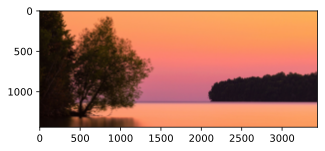

In [2]:
d2l.set_figsize(figsize=(5, 3))
img = d2l.Image.open('../data/img/sunset.jpg')
d2l.plt.imshow(img)

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """
    @param aug：可能是一个函数
    """
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

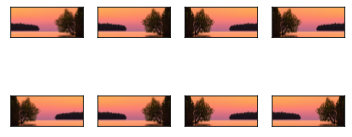

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

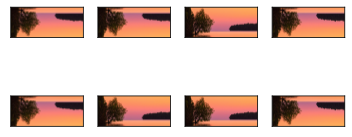

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

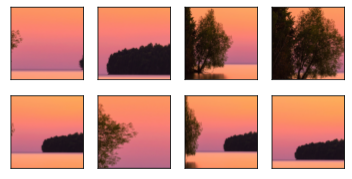

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    size=(200, 200), scale=(.1, 1), ratio=(.5, 2)
)
apply(img, shape_aug)

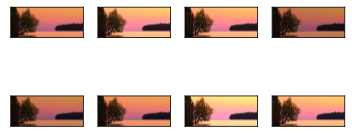

In [7]:
""" 改变颜色--亮度、对比度、饱和度、色调 """
apply(img, torchvision.transforms.ColorJitter(brightness=.5, contrast=0, saturation=0, hue=0))  # 亮度随机增减.5

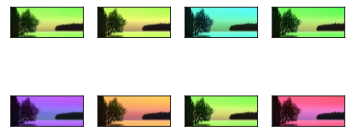

In [8]:
apply(img, torchvision.transforms.ColorJitter(hue=.5))

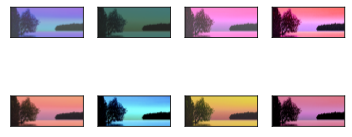

In [9]:
color_aug = torchvision.transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5, hue=.5)   # 设置同时随机更改图像的多个属性
apply(img, color_aug)   

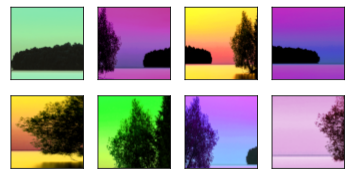

In [10]:
augs = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(),
    color_aug,
    shape_aug]
)
apply(img, augs)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

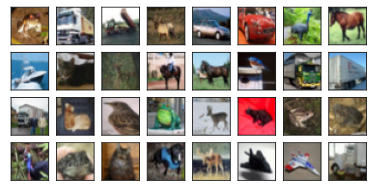

In [11]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data/", download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=.8)

In [12]:
""" ToTensor将图像转换为[N,C,H,W]，取值范围0~1 """
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root='../data/', train=is_train, transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

In [14]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """ 
    用多GPU进行小批量训练\n
    X、y放到devices[0] 
    @return: train_loss_sum, train_acc_sum
    """
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices=d2l.try_all_gpus()):
    """
    用多GPU进行模型训练
    但是又把模型放到了devices[0]上？？？
    """
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator('epoch', xlim=[1, num_epochs], ylim=[0, 1], legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(device=devices[0])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[2], metric[1] / metric[3], None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc {metric[1] / metric[2]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(devices)}')

In [15]:
batch_size, devices, net = 128, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

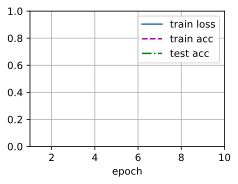

In [16]:
train_with_data_aug(train_augs, test_augs, net)